In [2]:
!nvidia-smi

Tue Feb  2 06:51:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# HW 3 - Neural POS Tagger

In this exercise, you are going to build a set of deep learning models on part-of-speech (POS) tagging using Tensorflow 2. Tensorflow is a deep learning framwork developed by Google to provide an easier way to use standard layers and networks.

To complete this exercise, you will need to build deep learning models for POS tagging in Thai using NECTEC's ORCHID corpus. You will build one model for each of the following type:

- Neural POS Tagging with Word Embedding using Fixed / non-Fixed Pretrained weights
- Neural POS Tagging with Viterbi / Marginal CRF

Pretrained word embeddding are already given for you to use (albeit, a very bad one).

We also provide the code for data cleaning, preprocessing and some starter code for tensorflow 2 in this notebook but feel free to modify those parts to suit your needs. Feel free to use additional libraries (e.g. scikit-learn) as long as you have a model for each type mentioned above.

### Don't forget to change hardware accelrator to GPU in runtime on Google Colab ###

## 1. Setup and Preprocessing

We use POS data from [ORCHID corpus](https://www.nectec.or.th/corpus/index.php?league=pm), which is a POS corpus for Thai language.
A method used to read the corpus into a list of sentences with (word, POS) pairs have been implemented already. The example usage has shown below.
We also create a word vector for unknown word by random.

In [3]:
%tensorflow_version 2.x

In [4]:
!wget https://www.dropbox.com/s/tuvrbsby4a5axe0/resources.zip
!unzip resources.zip

--2021-02-02 06:51:42--  https://www.dropbox.com/s/tuvrbsby4a5axe0/resources.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/tuvrbsby4a5axe0/resources.zip [following]
--2021-02-02 06:51:42--  https://www.dropbox.com/s/raw/tuvrbsby4a5axe0/resources.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc010e798bd177cbc3a199e8ddcf.dl.dropboxusercontent.com/cd/0/inline/BILDRpLpxR3EpKAC-tnbuOU7UMcrQPmA1e-KicqvG7IdNp1t0ioIwO300rohpn7joRdiB9s6_NwHEEInStYcicLL0OgYAICbZE2BpF0Z2rHrdg/file# [following]
--2021-02-02 06:51:43--  https://uc010e798bd177cbc3a199e8ddcf.dl.dropboxusercontent.com/cd/0/inline/BILDRpLpxR3EpKAC-tnbuOU7UMcrQPmA1e-KicqvG7IdNp1t0ioIwO300rohpn7joRdiB9s6_NwHEEInStYcicLL0OgYAICbZE2BpF0Z2rHrdg/file
Resolving uc0

In [5]:
!pip install python-crfsuite
!pip install tensorflow-addons
!pip install tf2crf

     |████████████████████████████████| 747kB 8.2MB/s 


In [6]:
%tensorflow_version 2.x

In [7]:
from data.orchid_corpus import get_sentences
import numpy as np
import numpy.random
import tensorflow as tf
np.random.seed(42)

In [8]:
yunk_emb =np.random.randn(32)
train_data = get_sentences('train')
test_data = get_sentences('test')
print(train_data[0])

[('การ', 'FIXN'), ('ประชุม', 'VACT'), ('ทาง', 'NCMN'), ('วิชาการ', 'NCMN'), ('<space>', 'PUNC'), ('ครั้ง', 'CFQC'), ('ที่ 1', 'DONM')]


Next, we load pretrained weight embedding using pickle. The pretrained weight is a dictionary which map a word to its embedding.

In [9]:
import pickle
fp = open('basic_ff_embedding.pt', 'rb')
embeddings = pickle.load(fp)
fp.close()

The given code below generates an indexed dataset(each word is represented by a number) for training and testing data. The index 0 is reserved for padding to help with variable length sequence. (Additionally, You can read more about padding here [https://machinelearningmastery.com/data-preparation-variable-length-input-sequences-sequence-prediction/])

## 2. Prepare Data

In [10]:
word_to_idx ={}
idx_to_word ={}
label_to_idx = {}
for sentence in train_data:
    for word,pos in sentence:
        if word not in word_to_idx:
            word_to_idx[word] = len(word_to_idx)+1
            idx_to_word[word_to_idx[word]] = word
        if pos not in label_to_idx:
            label_to_idx[pos] = len(label_to_idx)+1
word_to_idx['UNK'] = len(word_to_idx)

n_classes = len(label_to_idx.keys())+1

This section is tweaked a little from the demo, word2features will return word index instead of features, and sent2labels will return a sequence of word indices in the sentence.

In [11]:
def word2features(sent, i, emb):
    word = sent[i][0]
    if word in word_to_idx :
        return word_to_idx[word]
    else :
        return word_to_idx['UNK']

def sent2features(sent, emb_dict):
    return np.asarray([word2features(sent, i, emb_dict) for i in range(len(sent))])

def sent2labels(sent):
    return numpy.asarray([label_to_idx[label] for (word, label) in sent],dtype='int32')

def sent2tokens(sent):
    return [word for (word, label) in sent]

In [12]:
sent2features(train_data[100], embeddings)

array([ 29, 327,   5, 328])

Next we create train and test dataset, then we use tensorflow 2 to post-pad the sequence to max sequence with 0. Our labels are changed to a one-hot vector.

In [13]:
%%time
x_train = np.asarray([sent2features(sent, embeddings) for sent in train_data])
y_train = [sent2labels(sent) for sent in train_data]
x_test = [sent2features(sent, embeddings) for sent in test_data]
y_test = [sent2labels(sent) for sent in test_data]

CPU times: user 378 ms, sys: 1.56 ms, total: 380 ms
Wall time: 386 ms


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [14]:
x_train=tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=None, dtype='int32', padding='post', truncating='pre', value=0.)
y_train=tf.keras.preprocessing.sequence.pad_sequences(y_train, maxlen=None, dtype='int32', padding='post', truncating='pre', value=0.)
x_test=tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=102, dtype='int32', padding='post', truncating='pre', value=0.)
y_temp =[]
for i in range(len(y_train)):
    y_temp.append(np.eye(n_classes)[y_train[i]][np.newaxis,:])
y_train = np.asarray(y_temp).reshape(-1,102,n_classes)
del(y_temp)

In [15]:
print(x_train[100],x_train.shape)
print(y_train[100][3],y_train.shape)

[ 29 327   5 328   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] (18500, 102)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] (18500, 102, 48)


## 3. Evaluate

Our output from tf keras is a distribution of problabilities on all possible label. outputToLabel will return an indices of maximum problability from output sequence.

evaluation_report is the same as in the demo

In [16]:
def outputToLabel(yt,seq_len):
    out = []
    for i in range(0,len(yt)):
        if(i==seq_len):
            break
        out.append(np.argmax(yt[i]))
    return out

In [17]:
import pandas as pd
from IPython.display import display

def evaluation_report(y_true, y_pred):
    # retrieve all tags in y_true
    tag_set = set()
    for sent in y_true:
        for tag in sent:
            tag_set.add(tag)
    for sent in y_pred:
        for tag in sent:
            tag_set.add(tag)
    tag_list = sorted(list(tag_set))
    
    # count correct points
    tag_info = dict()
    for tag in tag_list:
        tag_info[tag] = {'correct_tagged': 0, 'y_true': 0, 'y_pred': 0}

    all_correct = 0
    all_count = sum([len(sent) for sent in y_true])
    for sent_true, sent_pred in zip(y_true, y_pred):
        for tag_true, tag_pred in zip(sent_true, sent_pred):
            if tag_true == tag_pred:
                tag_info[tag_true]['correct_tagged'] += 1
                all_correct += 1
            tag_info[tag_true]['y_true'] += 1
            tag_info[tag_pred]['y_pred'] += 1
    accuracy = (all_correct / all_count) * 100
            
    # summarize and make evaluation result
    eval_list = list()
    for tag in tag_list:
        eval_result = dict()
        eval_result['tag'] = tag
        eval_result['correct_count'] = tag_info[tag]['correct_tagged']
        precision = (tag_info[tag]['correct_tagged']/tag_info[tag]['y_pred'])*100 if tag_info[tag]['y_pred'] else '-'
        recall = (tag_info[tag]['correct_tagged']/tag_info[tag]['y_true'])*100 if (tag_info[tag]['y_true'] > 0) else 0
        eval_result['precision'] = precision
        eval_result['recall'] = recall
        eval_result['f_score'] = (2*precision*recall)/(precision+recall) if (type(precision) is float and recall > 0) else '-'
        
        eval_list.append(eval_result)

    eval_list.append({'tag': 'accuracy=%.2f' % accuracy, 'correct_count': '', 'precision': '', 'recall': '', 'f_score': ''})
    
    df = pd.DataFrame.from_dict(eval_list)
    df = df[['tag', 'precision', 'recall', 'f_score', 'correct_count']]
    display(df)

## 4. Train a model

In [18]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dense,GRU,Reshape,TimeDistributed,Bidirectional,Dropout,Masking
from tensorflow.keras.optimizers import Adam

The model is this section is separated to two groups

- Neural POS Tagger (4.1)
- Neural CRF POS Tagger (4.2)

## 4.1.1 Neural POS Tagger  (Example)

We create a simple Neural POS Tagger as an example for you. This model dosen't use any pretrained word embbeding so it need to use Embedding layer to train the word embedding from scratch.

Instead of using tensorflow.keras.models.Sequential, we use tensorflow.keras.models.Model. The latter is better as it can have multiple input/output, of which Sequential model could not. Due to this reason, the Model class is widely used for building a complex deep learning model.

In [19]:
inputs = Input(shape=(102,), dtype='int32')
output = (Embedding(len(word_to_idx),32,input_length=102,mask_zero=True))(inputs)
output = Bidirectional(GRU(32, return_sequences=True))(output)
output = Dropout(0.2)(output)
output = TimeDistributed(Dense(n_classes,activation='softmax'))(output)
model = Model(inputs, output)
model.compile(optimizer=Adam(lr=0.001),  loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()
model.fit(x_train,y=y_train, batch_size=64,epochs=10,verbose=1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 102)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 102, 32)           480608    
_________________________________________________________________
bidirectional (Bidirectional (None, 102, 64)           12672     
_________________________________________________________________
dropout (Dropout)            (None, 102, 64)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 102, 48)           3120      
Total params: 496,400
Trainable params: 496,400
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
290/290 [==============================] - 21s 25ms/step - loss: 0.3940 - categorical_accuracy: 0.3876
Epoch 2

In [20]:
%%time
model.fit(x_train,y_train,batch_size=64,epochs=10,verbose=1)

Epoch 1/10
290/290 [==============================] - 7s 23ms/step - loss: 0.0180 - categorical_accuracy: 0.9618
Epoch 2/10
290/290 [==============================] - 7s 23ms/step - loss: 0.0174 - categorical_accuracy: 0.9629
Epoch 3/10
290/290 [==============================] - 7s 24ms/step - loss: 0.0167 - categorical_accuracy: 0.9643
Epoch 4/10
290/290 [==============================] - 7s 24ms/step - loss: 0.0161 - categorical_accuracy: 0.9657
Epoch 5/10
290/290 [==============================] - 7s 24ms/step - loss: 0.0155 - categorical_accuracy: 0.9668
Epoch 6/10
290/290 [==============================] - 7s 24ms/step - loss: 0.0150 - categorical_accuracy: 0.9677
Epoch 7/10
290/290 [==============================] - 7s 26ms/step - loss: 0.0145 - categorical_accuracy: 0.9688
Epoch 8/10
290/290 [==============================] - 7s 23ms/step - loss: 0.0140 - categorical_accuracy: 0.9697
Epoch 9/10
290/290 [==============================] - 7s 24ms/step - loss: 0.0135 - categorical_

In [22]:
%%time
model.save_weights('./data/my_pos_no_crf.h5')
#model.load_weights('./data/my_pos_no_crf.h5')
y_pred=model.predict(x_test)
ypred = [outputToLabel(y_pred[i],len(y_test[i])) for i in range(len(y_pred))]
evaluation_report(y_test, ypred)

,tag,precision,recall,f_score,correct_count
0,1,99.891,99.4844,99.6873,3666
1,2,95.297,93.356,94.3165,7700
2,3,91.2757,95.275,93.2325,16091
3,4,99.9302,99.644,99.7869,12876
4,5,88,98.5075,92.9577,66
5,6,98.1481,91.3793,94.6429,477
6,7,97.4359,96.8735,97.1539,2014
7,8,76.4706,53.253,62.7841,221
8,9,50.5376,63.8587,56.4226,235
9,10,61.9454,43.2658,50.9474,363


CPU times: user 3.87 s, sys: 196 ms, total: 4.07 s
Wall time: 3.71 s


## 4.2 CRF Viterbi

Your next task is to incorporate Conditional random fields (CRF) to your model.

To use the CRF layer, you need to use an extension repository for tensorflow library, call tf2crf. If you want to see the detailed implementation, you should read the official tensorflow extention of CRF (https://www.tensorflow.org/addons/api_docs/python/tfa/text).

tf2crf link :  https://github.com/xuxingya/tf2crf

For inference, you should look at crf.py at the method call and view the input/output argmunets. 
Link : https://github.com/xuxingya/tf2crf/blob/master/tf2crf/crf.py



### 4.2.1 CRF without pretrained weight
### #TODO 1
Incoperate CRF layer to your model in 4.1. CRF is quite complex compare to previous example model, so you should train it with more epoch, so it can converge.

To finish this excercise you must train the model and show the evaluation report with this model as shown in the example.

Do not forget to save this model weight.

In [23]:
from tf2crf import CRF, ModelWithCRFLoss

In [33]:
# INSERT YOUR CODE HERE

inputs = Input(shape=(102,), dtype='int32')
output = (Embedding(len(word_to_idx),32,input_length=102,mask_zero=True))(inputs)
output = Bidirectional(GRU(32, return_sequences=True))(output)
output = Dropout(0.2)(output)
output = TimeDistributed(Dense(n_classes, activation=None))(output)
crf = CRF(dtype='float32')
output = crf(output)
base_model = Model(inputs, output)
model_crf = ModelWithCRFLoss(base_model)
model_crf.compile(optimizer=Adam(lr=0.001))

model_crf.build((102,1))
model_crf.summary()
model_crf.fit(x=x_train,y=y_train.argmax(axis=2), batch_size=64,epochs=10,verbose=1)

Model: "model_with_crf_loss_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Functional)         ((None, 102), (None, 102, 498706    
Total params: 498,708
Trainable params: 498,704
Non-trainable params: 4
_________________________________________________________________
Epoch 1/10
290/290 [==============================] - 111s 345ms/step - crf_loss: 25.6719 - accuracy: 0.5722
Epoch 2/10
290/290 [==============================] - 99s 341ms/step - crf_loss: 5.7208 - accuracy: 0.9088
Epoch 3/10
290/290 [==============================] - 99s 340ms/step - crf_loss: 3.5697 - accuracy: 0.9372
Epoch 4/10
290/290 [==============================] - 99s 342ms/step - crf_loss: 2.8536 - accuracy: 0.9469
Epoch 5/10
290/290 [==============================] - 98s 340ms/step - crf_loss: 2.4877 - accuracy: 0.9523
Epoch 6/10
290/290 [==============================] - 98s 340ms/step - crf_loss: 2.2528 - accura

In [34]:
model_crf.fit(x=x_train,y=y_train.argmax(axis=2), batch_size=64,epochs=10,verbose=1)

Epoch 1/10
290/290 [==============================] - 98s 337ms/step - crf_loss: 1.7343 - accuracy: 0.9636
Epoch 2/10
290/290 [==============================] - 97s 334ms/step - crf_loss: 1.6694 - accuracy: 0.9647
Epoch 3/10
290/290 [==============================] - 99s 342ms/step - crf_loss: 1.6057 - accuracy: 0.9659
Epoch 4/10
290/290 [==============================] - 98s 337ms/step - crf_loss: 1.5685 - accuracy: 0.9670
Epoch 5/10
290/290 [==============================] - 99s 341ms/step - crf_loss: 1.4907 - accuracy: 0.9683
Epoch 6/10
290/290 [==============================] - 98s 339ms/step - crf_loss: 1.4432 - accuracy: 0.9693
Epoch 7/10
290/290 [==============================] - 98s 338ms/step - crf_loss: 1.3958 - accuracy: 0.9702
Epoch 8/10
290/290 [==============================] - 99s 343ms/step - crf_loss: 1.3527 - accuracy: 0.9715
Epoch 9/10
290/290 [==============================] - 97s 336ms/step - crf_loss: 1.2911 - accuracy: 0.9722
Epoch 10/10
290/290 [================

In [35]:
%%time
model_crf.save_weights('./data/my_pos_crf.h5')
# model_crf.load_weights('./data/my_pos_crf.h5')
y_pred=model_crf.predict(x_test)[1]
ypred = [outputToLabel(y_pred[i],len(y_test[i])) for i in range(len(y_pred))]
evaluation_report(y_test, ypred)

,tag,precision,recall,f_score,correct_count
0,1,99.8641,99.7015,99.7827,3674
1,2,94.681,94.0955,94.3874,7761
2,3,90.7904,96.3704,93.4972,16276
3,4,99.9146,99.644,99.7791,12876
4,5,91.6667,98.5075,94.964,66
5,6,99.1561,90.0383,94.3775,470
6,7,97.6654,96.5849,97.1221,2008
7,8,76.5957,52.0482,61.9799,216
8,9,58.7302,60.3261,59.5174,222
9,10,61.8214,42.0739,50.0709,353


CPU times: user 23.5 s, sys: 4.11 s, total: 27.6 s
Wall time: 16.9 s



### 4.2.2 CRF with pretrained weight

### #TODO 2

We would like you create a neural CRF POS tagger model  with the pretrained word embedding as an input and the word embedding is trainable (not fixed). To finish this excercise you must train the model and show the evaluation report with this model as shown in the example.

Please note that the given pretrained word embedding only have weights for the vocabuary in BEST corpus.

Optionally, you can use your own pretrained word embedding.

#### Hint: You can get the embedding from get_embeddings function from embeddings/emb_reader.py . 

(You may want to read about Tensorflow Masking layer and Trainable parameter)

In [36]:
from embeddings.emb_reader import get_embeddings
pretrained_embeddings = get_embeddings()
(hits, misses) = (0, 0)
num_tokens = len(word_to_idx)
embedding_dim = pretrained_embeddings[list(pretrained_embeddings.keys())[0]].shape[0]
embedding_matrix = np.zeros((num_tokens, embedding_dim))

for word, i in word_to_idx.items():
    embedding_vector = pretrained_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%s misses)" % (hits, misses))

Converted 3706 words (11313 misses)


In [37]:
# INSERT YOUR CODE HERE
inputs = Input(shape=(102,), dtype='int32')
output = (Embedding(num_tokens, embedding_dim,input_length=102,
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=True, mask_zero=True))(inputs)
output = Bidirectional(GRU(32, return_sequences=True))(output)
output = Dropout(0.2)(output)
output = TimeDistributed(Dense(n_classes, activation=None))(output)
crf = CRF(dtype='float32')
output = crf(output)
base_model = Model(inputs, output)
model_crf_pre = ModelWithCRFLoss(base_model)
model_crf_pre.compile(optimizer=Adam(lr=0.001))

model_crf_pre.build((102,1))
model_crf_pre.summary()
model_crf_pre.fit(x=x_train,y=y_train.argmax(axis=2), batch_size=64,epochs=10,verbose=1)

Model: "model_with_crf_loss_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_5 (Functional)         ((None, 102), (None, 102, 985458    
Total params: 985,460
Trainable params: 985,456
Non-trainable params: 4
_________________________________________________________________
Epoch 1/10
290/290 [==============================] - 108s 340ms/step - crf_loss: 21.7243 - accuracy: 0.6452
Epoch 2/10
290/290 [==============================] - 100s 344ms/step - crf_loss: 4.8584 - accuracy: 0.9195
Epoch 3/10
290/290 [==============================] - 99s 342ms/step - crf_loss: 3.1912 - accuracy: 0.9425
Epoch 4/10
290/290 [==============================] - 99s 343ms/step - crf_loss: 2.6055 - accuracy: 0.9507
Epoch 5/10
290/290 [==============================] - 98s 339ms/step - crf_loss: 2.2992 - accuracy: 0.9545
Epoch 6/10
290/290 [==============================] - 101s 348ms/step - crf_loss: 2.1139 - accu

In [39]:
%%time
model_crf_pre.save_weights('./data/my_pos_crf_pre.h5')
# model_crf_pre.load_weights('./data/my_pos_crf_pre.h5')
result = model_crf_pre.predict(x_test) #crf will return 4 items
y_pred = result[1]
ypred = [outputToLabel(y_pred[i],len(y_test[i])) for i in range(len(y_pred))]
evaluation_report(y_test, ypred)

,tag,precision,recall,f_score,correct_count
0,1,99.8641,99.6744,99.7691,3673
1,2,94.388,94.6169,94.5023,7804
2,3,90.4903,96.0625,93.1932,16224
3,4,99.9922,99.6363,99.8139,12875
4,5,88,98.5075,92.9577,66
5,6,99.568,88.3142,93.6041,461
6,7,97.2662,97.5469,97.4063,2028
7,8,70.7246,58.7952,64.2105,244
8,9,68.9024,61.413,64.9425,226
9,10,61.6088,40.1669,48.6291,337


CPU times: user 24 s, sys: 4.19 s, total: 28.2 s
Wall time: 17.3 s


### #TODO 3
Compare the result between all neural tagger models in 4.1 and 4.2.x and provide a convincing reason and example for the result of these models (which model perform better, why?)

(If you use your own weight please state so in the answer)

<b>Write your answer here :</b>

There is 3 methods in this experiment to perform in PoS tagging task which are "nn", "nn_crf", and "nn_crf with pretrained weight".

Accuracy:

    - acc of nn: 93.02%                                    [with epoch=20]
    - acc of nn_crf: 
        - 93.06%                                           [with epoch=20]
        - 92.30%                                           [with epoch=30 the acc is decrease -> overfit]
    - acc of nn_crf with pretrained weight: 93.08%         [with epoch=10 training more than this will make acc drop in my experiment.]

    summary: nn_crf with pretrained > nn_crf > nn . (however they are diffrent a bit < 0.4%)

Training time:

    - nn: 20 epoch (each epoch=7 sec)                       -> cost 20x7 = "140 sec"
    - nn_crf: 20 epoch (each epoch=100 sec)                 -> cost 20*100 = "2000 sec"
    - nn_crf with pretrained: 10 epoch (each epoch=100 sec) -> cost 10*100 = "1000 sec"

    summary: nn <<< nn_crf with pretrained << nn_crf (in this experiment) -> all model have nearly acc.

Model Speed:
    
    we will compare this part by using wall time while predicting of the model to compare speed of the model

    - nn:                                                    3.71 sec
    - nn_crf:                                                16.9 sec
    - nn_crf with pretrained:                                17.3 sec

     summary: nn <<< nn_crf = nn_crf with pretrained(equal model size)
    


Summary: 
for my point of view, I will choose nn model because nn give the reasonable accuracy with faster training and faster model.

### #TODO 4

Upon inference, the model also returns its transition matrix, which is learned during training. Your task is to observe and report whether the returned matrix is sensible. You can provide some examples to support your argument.

#### Hint : The transition matrix must have the shape  of (num_class, num_class).

<b>Write your answer here :</b>

About transition matrix:

- Transition matrix will have size of (n_classes,n_classes). In this case it will be (48,48).

- The transition matrix will have row(i) and column(j). While reading the transition matrix, you should look at row(i) first and then follow with column(j). So it means that the transition score you get is the transition score from tag i to tag j.
    
- The transition score is the score that model learn from the data:
  - if tag i appear, tag j have a high chance to appear after it. So the model will give high the transition score from tag i to tag j.
  - Opposite to the high score, if the model give the low transition score to that pair of tag, it means that tag j usually not appear after tag i.

Analysis:  
- As you can see from the heatmap of transition matrix below,
    - the bright spot means that the transition score is high.
    - the dark spot means that the transition sccore is low.

- So, I pick about 3 bright spot(high transition score) to analysis and all of them seem reasonable.
    1.   from NTTL(Title noun) to NPRP(Proper noun) which seem resonable because title of noun (such as ดร.) must follow with proper noun.
    2.   from FIXV(Adverbial prefix) to VSTA(Stative verb) which seem ืreasonable because Adverbial prefix(such as อย่าง) usually follow with stative verb(such as ชอบ รัก) but not match with some stative verb (such as เห็น รู้).
    3.   from FIXV(Adverbial prefix) to VATT(Attributive verb) which seem ืreasonable because Adverbial prefix(such as อย่าง) usually follow with attributive verb(such as อ้วน ดี สวย).

- Then, I pick about 3 dark spot(low transition score) to analysis and all of them seem reasonable.
    1.   from FIXV(Adverbial prefix) to NCMN(Cardinal number) which is seems reasonable because adverbial prefix(such as อย่าง) should not follow with cardinal number(such as 1 2).
    2.   from CNIT(Unit classifier) to NPRP(Proper noun) which is seems reasonable because unit classifier(such as ตัว เล่ม) should not follow with proper noun.
    3.   from XVAE(Post-verb auxiliary) to DDAQ(Definite determiner  following quantitative expression) which is seems reasonable because post-verb auxiliary(such as ไป ขึ้น) should not follow with DDAQ(such as พอดี ถ้วน)

summary: I think that the transition matrix seems sensible with all reasons above.


In [40]:
transition_matrix = crf.transitions.numpy()
print('transition matrix shape:',transition_matrix.shape)

transition matrix shape: (48, 48)


In [41]:
transition_matrix

array([[-0.10593769, -0.03279777, -0.37488276, ...,  0.15101498,
         0.3019332 , -0.20515718],
       [-0.14785716, -0.4685588 ,  0.09250808, ...,  0.00943844,
        -0.13445269, -0.25476408],
       [-0.12834364,  0.11082927, -0.46854505, ..., -0.26941627,
        -0.00110858,  0.17365965],
       ...,
       [-0.12138613, -0.02356436, -0.13002276, ..., -0.12561345,
        -0.34274864, -0.165671  ],
       [-0.0289832 , -0.30262512, -0.4335802 , ..., -0.11440538,
        -0.03528374, -0.19618472],
       [-0.11082111, -0.1415203 , -0.27420795, ...,  0.13307239,
        -0.24492078, -0.08499394]], dtype=float32)

In [42]:
tag_list = [0]*(len(label_to_idx)+1)
for tag_name,idx in label_to_idx.items():
    tag_list[idx] = tag_name

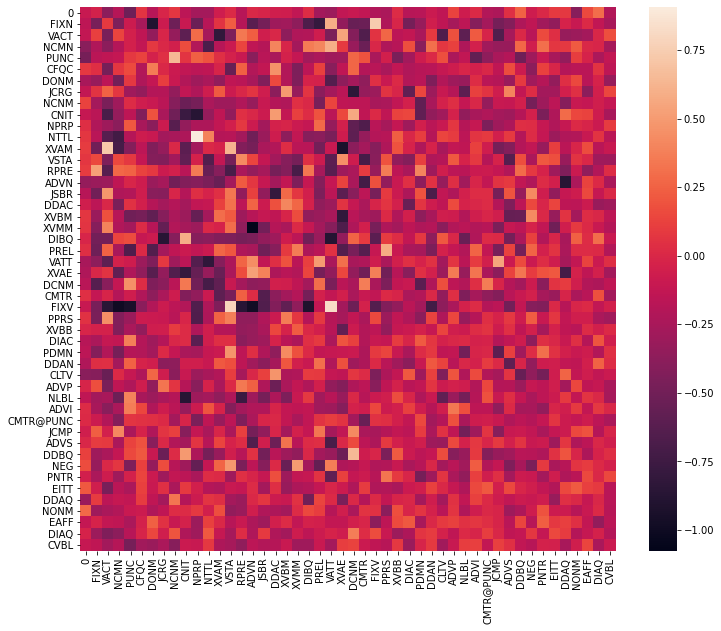

In [43]:
import seaborn as sns
import matplotlib.pylab as plt

fig, ax = plt.subplots(figsize=(12,10)) 
ax = sns.heatmap(transition_matrix, xticklabels=tag_list, yticklabels=tag_list)
plt.show()